In [36]:
import pandas as pd
import datetime 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from astral.sun import sun
from astral import Observer
from astral import LocationInfo
from astral.location import Location

In [16]:
data_path = "2024_ML_project_forecasting"
#df = pd.read_csv("Data/epfl_campus_demand.csv").rename(columns={"Unnamed: 0":"date"})
df = pd.read_csv(data_path+"\dataset_v2.csv").rename(columns={"Unnamed: 0":"date"})
df

,date,total_p_demand [kW],ghi,temp,wind
0,2022-01-01 00:00:00+00:00,NaN,0.0,4.12,1.10
1,2022-01-01 01:00:00+00:00,NaN,0.0,3.92,1.31
2,2022-01-01 02:00:00+00:00,NaN,0.0,3.67,1.24
3,2022-01-01 03:00:00+00:00,NaN,0.0,3.51,1.17
4,2022-01-01 04:00:00+00:00,NaN,0.0,3.25,1.17
...,...,...,...,...,...
24859,2024-11-01 19:00:00+00:00,NaN,NaN,NaN,NaN
24860,2024-11-01 20:00:00+00:00,NaN,NaN,NaN,NaN
24861,2024-11-01 21:00:00+00:00,NaN,NaN,NaN,NaN
24862,2024-11-01 22:00:00+00:00,NaN,NaN,NaN,NaN


In [17]:
N_empty = sum(df["total_p_demand [kW]"].isna())
print(str(N_empty/len(df))+" of value are missing an estimated demand")
#Every timesteps before 2022-04-23 10:00 is missing (idx < 2458), Everything after 2024-06-17 05:00 is missing (idx > 21557)

# Applying the new range
df= df[(df.index >= 2458) & (df.index<=21557)].reset_index(drop=True)
N_empty = sum(df["total_p_demand [kW]"].isna())
print(str(N_empty/len(df))+" of value are missing an estimated demand with the new date range")

0.26906370656370654 of value are missing an estimated demand
0.048481675392670155 of value are missing an estimated demand with the new date range


There are 3395 different temp values
Ranging from -13.22°C to 32.73°C
Mean value 11.69025392670157,
Median value 11.46,
Standert Deviation 7.827060855861893


<Axes: xlabel='temp'>

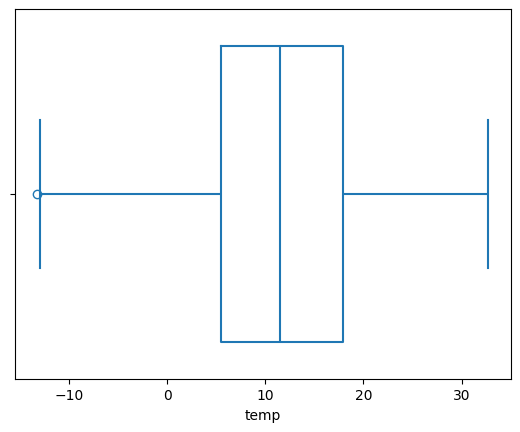

In [18]:
# remove non feasible temps:
df.loc[df[df.temp<-273].index,"temp"] = None
#Print temp statistics:
print("There are "+str(df.temp.nunique())+ " different temp values")
print("Ranging from "+str(df.temp.min())+"°C to "+str(df.temp.max())+"°C") #No outliers
print("Mean value "+str(df.temp.mean())+",\nMedian value "+str(df.temp.median())+",\nStandert Deviation "+str(df.temp.std())) # Which is indeed noticed on mean and median
sns.boxplot(x=df.temp,fill=False)

In [96]:
# Remove the 5% missing data because I don't think that it is worth to approximate them as it is the purpose of the study
#df_clean = df[df["total_p_demand [kW]"].isna()==False].reset_index().rename(columns={"index":"timestamp_0"})
df_clean = df.copy().reset_index().rename(columns={"index":"timestamp_0"})

# Creating different time steps that we could use 
df_clean.date = pd.to_datetime(df_clean.date)
df_clean["timestamp"] = df_clean['date'].astype('int64') // (10**9*60*60) #Hour by hour from original date #// (10**9*60) # to convert into minutes since the original date
df_clean.head()

,timestamp_0,date,total_p_demand [kW],ghi,temp,wind,timestamp
0,0,2022-04-13 10:00:00+00:00,8260.0,733.01,15.20,0.76,458290
1,1,2022-04-13 11:00:00+00:00,7780.0,677.00,16.13,1.10,458291
2,2,2022-04-13 12:00:00+00:00,7700.0,651.00,17.11,1.45,458292
3,3,2022-04-13 13:00:00+00:00,7890.0,475.00,17.69,1.38,458293
4,4,2022-04-13 14:00:00+00:00,8390.0,584.00,17.95,1.24,458294


In [97]:
# temp data:
print("There are "+str(df_clean.temp.nunique())+ " different temp values")
print("Ranging from "+str(df_clean.temp.min())+"°C to "+str(df_clean.temp.max())+"°C") #No outliers
print("Mean value "+str(df_clean.temp.mean())+",\nMedian value "+str(df_clean.temp.median())+",\nStandart Deviation "+str(df_clean.temp.std()))

# ghi data:
print("\n\nThere are "+str(df_clean.ghi.nunique())+ " different ghi values")
print("Ranging from "+str(df_clean.ghi.min())+"W/m^2 to "+str(df_clean.ghi.max())+"W/m^2") #No outliers
print("Mean value "+str(df_clean.ghi.mean())+",\nMedian value "+str(df_clean.ghi.median())+",\nStandart Deviation "+str(df_clean.ghi.std()))

# wind data:
print("\n\nThere are "+str(df_clean.wind.nunique())+ " different wind values")
print("Ranging from "+str(df_clean.wind.min())+"m/s to "+str(df_clean.wind.max())+"m/s") #No outliers
print("Mean value "+str(df_clean.wind.mean())+",\nMedian value "+str(df_clean.wind.median())+",\nStandart Deviation "+str(df_clean.wind.std()))

# demand data
print("\n\nThere are "+str(df_clean["total_p_demand [kW]"].nunique())+ " different demand values")
print("Ranging from "+str(df_clean["total_p_demand [kW]"].min())+"kW to "+str(df_clean["total_p_demand [kW]"].max())+"kW") #No outliers
print("Mean value "+str(df_clean["total_p_demand [kW]"].mean())+",\nMedian value "+str(df_clean["total_p_demand [kW]"].median())+",\nStandart Deviation "+str(df_clean["total_p_demand [kW]"].std())) # Which is indeed noticed on mean and median
#sns.boxplot(x=df_clean["total_p_demand [kW]"],fill=False)

There are 3395 different temp values
Ranging from -13.22°C to 32.73°C
Mean value 11.69025392670157,
Median value 11.46,
Standart Deviation 7.827060855861893


There are 3737 different ghi values
Ranging from 0.0W/m^2 to 984.01W/m^2
Mean value 162.38451308900525,
Median value 2.0,
Standart Deviation 246.1073879838547


There are 433 different wind values
Ranging from 0.0m/s to 6.48m/s
Mean value 1.366968062827225,
Median value 1.24,
Standart Deviation 0.7264598901266828


There are 11736 different demand values
Ranging from 4641.559530116667kW to 15450.0kW
Mean value 7953.292386781308,
Median value 7777.20835275,
Standart Deviation 1488.962234355655


In [ ]:
# creating continuous data for year, month, day and hour data
df_clean["year"] = df_clean.date.dt.year
df_clean["month"] = df_clean.date.dt.month
df_clean["day"] = df_clean.date.dt.day
df_clean["hour"] = df_clean.date.dt.hour

# Add data for if it is monday, tuesday, .... , sunday
days = ['monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday', 'sunday']
# Iterate through days and add new columns
for i, day in enumerate(days):
    df_clean[f'is_{day}'] = (df_clean.date.dt.dayofweek == i).astype(int)

# Add feature for season:
# Map months to seasons
season_mapping = {
    1: 'Winter', 2: 'Winter', 12: 'Winter',  # Winter
    3: 'Spring', 4: 'Spring', 5: 'Spring',   # Spring
    6: 'Summer', 7: 'Summer', 8: 'Summer',   # Summer
    9: 'Autumn', 10: 'Autumn', 11: 'Autumn'   # Autumn
}
df_clean['season'] = df_clean.date.dt.month.map(season_mapping)
df_dummies = pd.get_dummies(df_clean.season, prefix="is_")
df_clean = pd.concat([df_clean,df_dummies],axis=1)

In [ ]:
# Academic calendar
# 2022.04.15 - 2022.04.24 
# 2022.05.26
# 2022.06.06
# 2022.07.09 - 2022.09.20

# 2023.02.05 - 2023.02.19
# 2023.04.07 - 2023.04.16
# 2023.05.18
# 2023.05.29
# 2023.07.09 - 2023.09.18

# 2023.12.22 - 2024.01.15
# 2024.02.04 - 2024.02.18
# 2024.03.29 - 2024.04.07
# 2024.04.12
# 2024.05.09
# 2024.05.20

# Define the vacation date ranges as tuples (start_date, end_date)
vacation_periods = [
    ('2022-04-15', '2022-04-24'),
    ('2022-05-26', '2022-05-26'),
    ('2022-06-06', '2022-06-06'),
    ('2022-07-09', '2022-09-20'),
    
    ('2023-02-05', '2023-02-19'),
    ('2023-04-07', '2023-04-16'),
    ('2023-05-18', '2023-05-18'),
    ('2023-05-29', '2023-05-29'),
    ('2023-07-09', '2023-09-18'),
    
    ('2023-12-22', '2024-01-15'),
    ('2024-02-04', '2024-02-18'),
    ('2024-03-29', '2024-04-07'),
    ('2024-04-12', '2024-04-12'),
    ('2024-05-09', '2024-05-09'),
    ('2024-05-20', '2024-05-20'),
]

# Convert the start and end dates to datetime
vacation_periods = [(pd.to_datetime(start), pd.to_datetime(end)) for start, end in vacation_periods]

# Function to check if a date falls within any vacation period
def is_on_vacation(date):
    for start, end in vacation_periods:
        if start <= date <= end:
            return True
    return False

# Apply the function to create a binary 'vacation' column
df_clean['is_on_vacation'] = df_clean.date.dt.tz_localize(None).apply(is_on_vacation)

In [ ]:
# Creating a New binary feauture that says if it is day or night at each datetime:
# Function to determine day or night
def is_day(row):
    date = row.date
    city = LocationInfo("Lausanne", "Switzerland", "Europe/Paris", 46.5212, 6.5653)
    lausanne = Location(city)
    # Calculate sunrise and sunset for that date
    s = sun(city.observer, date=date, tzinfo=lausanne.timezone)
    sunrise = s['sunrise']
    sunset = s['sunset']
    
    # Check if the timestamp is during the day
    return 1 if sunrise <= date <= sunset else 0

# Apply function to each row
df_clean['is_daylight'] = df_clean.apply(is_day,axis=1)
# the results for time steps are weird because they are based on timezone 0 as is the original data. --> to discuss

In [100]:
# creating featurs for sky clarity:

# Step 1: Compute a Seasonal Clear-Sky GHI (95th percentile by hour)
monthly_clear_sky = df_clean.groupby(['month', 'hour'])['ghi'].quantile(0.95).reset_index()
monthly_clear_sky.rename(columns={'ghi': 'clear_sky_ghi'}, inplace=True)
df_clean = pd.merge(df_clean, monthly_clear_sky, on=['month', 'hour'], how='left')
# Step 2: Compute Clear Sky Index (Kc)
df_clean['clear_sky_index'] = df_clean['ghi'] / df_clean['clear_sky_ghi']
# Step 3: Classify Sky Clarity
def classify_sky_clarity(kc):
    if kc > 0.8:
        return 'Clear'
    elif kc < 0.5:
        return 'Cloudy'
    else:
        return 'Partly Cloudy'
    
df_clean['sky_clarity'] = df_clean['clear_sky_index'].apply(classify_sky_clarity)

# Create binary variables
# Optional: Add a binary feature for clear skies
df_clean['is_sky_clear'] = (df_clean['clear_sky_index'] > 0.8)
df_clean['is_sky_cloudy'] = (df_clean['clear_sky_index'] < 0.5)

# We could also train a model that uses wind and temperature to cluster even better the cloudyness (unsupervised in 3 groups)

In [101]:
# Categories Wind speed

# Step 1: Define a function to categorize wind speed based on statistics
def categorize_wind_speed(wind_speed):
    if wind_speed <= 0.5:
        return 'wind_very_Low'
    elif 0.5 < wind_speed <= 1.5:
        return 'wind_Low'
    elif 1.5 < wind_speed <= 3.0:
        return 'wind_Medium'
    else:
        return 'wind_High'
    
df_clean['wind_speed_category'] = df_clean['wind'].apply(categorize_wind_speed)
df_dummies = pd.get_dummies(df_clean['wind_speed_category'], prefix='is_')
df_clean = pd.concat([df_clean, df_dummies],axis=1)

In [102]:
df_clean

,timestamp_0,date,total_p_demand [kW],ghi,temp,wind,timestamp,year,month,day,...,clear_sky_ghi,clear_sky_index,sky_clarity,is_sky_clear,is_sky_cloudy,wind_speed_category,is__wind_High,is__wind_Low,is__wind_Medium,is__wind_very_Low
0,0,2022-04-13 10:00:00+00:00,8260.000000,733.01,15.20,0.76,458290,2022,4,13,...,834.310,0.878582,Clear,True,False,wind_Low,False,True,False,False
1,1,2022-04-13 11:00:00+00:00,7780.000000,677.00,16.13,1.10,458291,2022,4,13,...,870.210,0.777973,Partly Cloudy,False,False,wind_Low,False,True,False,False
2,2,2022-04-13 12:00:00+00:00,7700.000000,651.00,17.11,1.45,458292,2022,4,13,...,867.110,0.750770,Partly Cloudy,False,False,wind_Low,False,True,False,False
3,3,2022-04-13 13:00:00+00:00,7890.000000,475.00,17.69,1.38,458293,2022,4,13,...,793.160,0.598870,Partly Cloudy,False,False,wind_Low,False,True,False,False
4,4,2022-04-13 14:00:00+00:00,8390.000000,584.00,17.95,1.24,458294,2022,4,13,...,682.010,0.856292,Clear,True,False,wind_Low,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19095,19095,2024-06-17 01:00:00+00:00,6392.588979,0.00,11.24,1.20,477385,2024,6,17,...,0.000,NaN,Partly Cloudy,False,False,wind_Low,False,True,False,False
19096,19096,2024-06-17 02:00:00+00:00,6401.600435,0.00,10.98,1.21,477386,2024,6,17,...,0.000,NaN,Partly Cloudy,False,False,wind_Low,False,True,False,False
19097,19097,2024-06-17 03:00:00+00:00,6447.578932,0.00,11.09,1.18,477387,2024,6,17,...,0.000,NaN,Partly Cloudy,False,False,wind_Low,False,True,False,False
19098,19098,2024-06-17 04:00:00+00:00,6828.860655,41.32,12.11,0.97,477388,2024,6,17,...,52.346,0.789363,Partly Cloudy,False,False,wind_Low,False,True,False,False


In [26]:
#df_clean.to_csv("Data/epfl_demand_clean.csv")